# Gausian Mixture Model for Bird Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats  
import statsmodels.api as sm


In [2]:
# data = pd.read_csv('ebd_US-CO_202001_202312_smp_relMar-2024/ebd_US-CO_202001_202312_smp_relMar-2024.txt', sep = '\t')
# data = data[['COMMON NAME', 'COUNTY', 'COUNTY CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'NUMBER OBSERVERS']]
# data.to_csv('bird_data.csv')

data = pd.read_csv('bird_data.csv')

print("DataFrame:")
print(data.head(5))


DataFrame:
   Unnamed: 0    COMMON NAME COUNTY COUNTY CODE   LATITUDE   LONGITUDE  \
0           0  Accipiter sp.  Adams   US-CO-001  39.947339 -104.747209   
1           1  American Crow  Adams   US-CO-001  39.797274 -104.931060   
2           2  American Crow  Adams   US-CO-001  39.789034 -104.905840   
3           3  American Crow  Adams   US-CO-001  39.830492 -104.948991   
4           4  American Crow  Adams   US-CO-001  39.830492 -104.948991   

  OBSERVATION DATE  NUMBER OBSERVERS  
0       2020-01-10               1.0  
1       2020-01-01               5.0  
2       2020-01-02               1.0  
3       2020-01-01              10.0  
4       2020-01-01              10.0  


In [3]:
# select only necessary columns
df = data[['COMMON NAME', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE']]

# subset for names that occur x number of times
# Step 1: Count the occurrences of each name
name_counts = df['COMMON NAME'].value_counts()

# Step 2: Define the threshold
threshold = 300000  # Example threshold

# Step 3: Filter names based on the count threshold
filtered_names = name_counts[name_counts > threshold].index.tolist()

# Step 4: Subset the original DataFrame using filtered names
df = df[df['COMMON NAME'].isin(filtered_names)]

print(df.shape[0])

2050313


In [4]:
# convert observation date column to datetime
df['OBSERVATION DATE'] = pd.to_datetime(df['OBSERVATION DATE'])

# define functions to filter data for each season
def filter_winter(date): # december to february
    return (date.month == 12) or (date.month == 1) or (date.month == 2)

def filter_spring(date): # march to may
    return (date.month == 3) or (date.month == 4) or (date.month == 5)

def filter_summer(date): # june to august
    return (date.month == 6) or (date.month == 7) or (date.month == 8)

def filter_fall(date): # september to november
    return (date.month == 9) or (date.month == 10) or (date.month == 11)

# Apply filters to create new dataframes for each season
winter_df = df[df['OBSERVATION DATE'].apply(filter_winter)]
spring_df = df[df['OBSERVATION DATE'].apply(filter_spring)]
summer_df = df[df['OBSERVATION DATE'].apply(filter_summer)]
fall_df = df[df['OBSERVATION DATE'].apply(filter_fall)]

# # Only grab rows from boulder co
# winter_df = winter_df[winter_df['COUNTY'] == 'Boulder']
# spring_df = spring_df[spring_df['COUNTY'] == 'Boulder']
# summer_df = summer_df[summer_df['COUNTY'] == 'Boulder']
# fall_df = fall_df[fall_df['COUNTY'] == 'Boulder']

# Print the dataframes for each season
print("Winter DataFrame:")
print(winter_df.head(5))
print("\nSpring DataFrame:")
print(spring_df.head(5))
print("\nSummer DataFrame:")
print(summer_df.head(5))
print("\nFall DataFrame:")
print(fall_df.head(5))

Winter DataFrame:
        COMMON NAME COUNTY   LATITUDE   LONGITUDE OBSERVATION DATE
528  American Robin  Adams  39.888856 -104.998648       2020-01-08
529  American Robin  Adams  39.962109 -104.760371       2020-01-11
530  American Robin  Adams  39.986929 -104.730928       2020-01-11
531  American Robin  Adams  39.945110 -104.773007       2020-01-11
532  American Robin  Adams  39.978662 -104.547627       2020-01-19

Spring DataFrame:
           COMMON NAME COUNTY   LATITUDE   LONGITUDE OBSERVATION DATE
268447  American Robin  Adams  39.815100 -104.880526       2020-03-30
268448  American Robin  Adams  39.938261 -104.750919       2020-03-04
268449  American Robin  Adams  39.942496 -104.745215       2020-03-04
268450  American Robin  Adams  39.942539 -104.744703       2020-03-07
268451  American Robin  Adams  39.942539 -104.744703       2020-03-25

Summer DataFrame:
            COMMON NAME COUNTY   LATITUDE   LONGITUDE OBSERVATION DATE
1343619  American Robin  Adams  39.940303 -104.7459

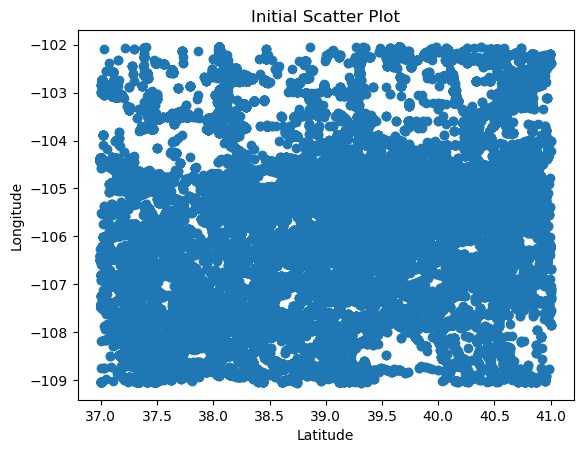

In [5]:
plt.scatter(df['LATITUDE'], df['LONGITUDE'])
plt.title('Initial Scatter Plot')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

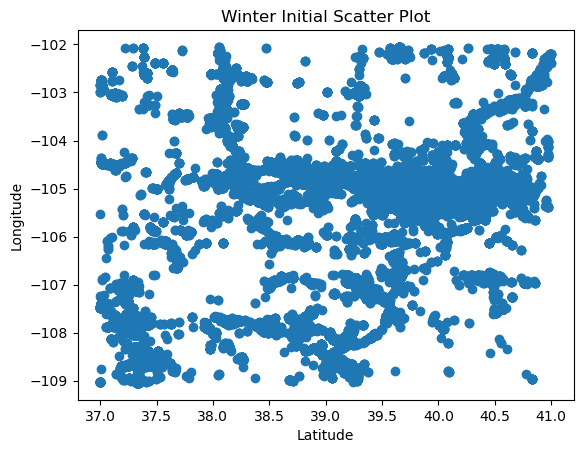

426226


In [6]:
plt.scatter(winter_df['LATITUDE'], winter_df['LONGITUDE'])
plt.title('Winter Initial Scatter Plot')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
print(winter_df.shape[0])

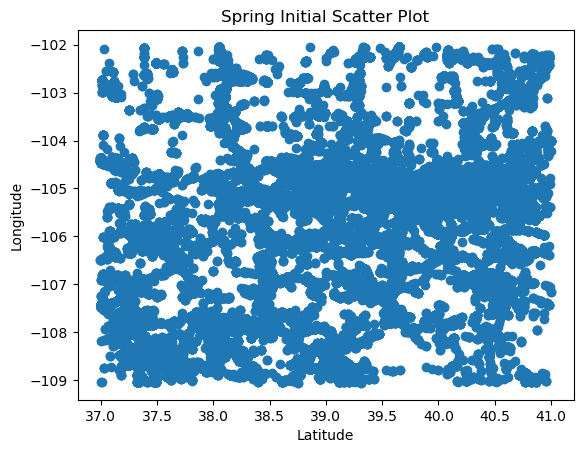

768253


In [7]:
plt.scatter(spring_df['LATITUDE'], spring_df['LONGITUDE'])
plt.title('Spring Initial Scatter Plot')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
print(spring_df.shape[0])

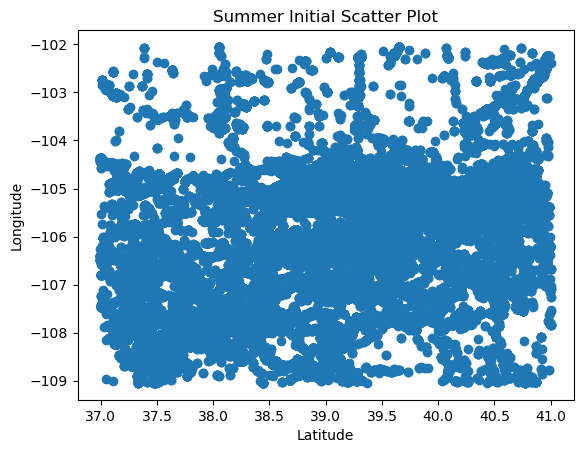

431840


In [8]:
plt.scatter(summer_df['LATITUDE'], summer_df['LONGITUDE'])
plt.title('Summer Initial Scatter Plot')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
print(summer_df.shape[0])

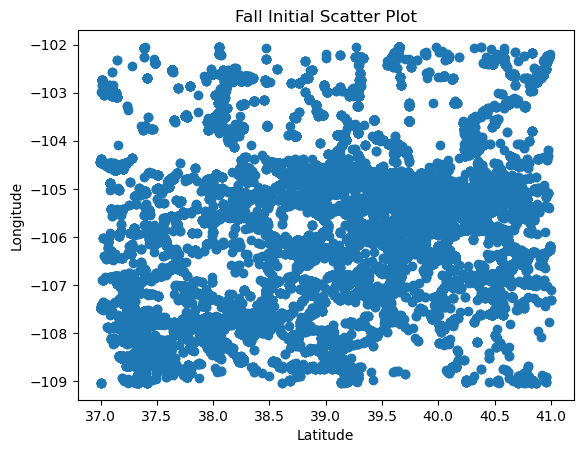

423994


In [9]:
plt.scatter(fall_df['LATITUDE'], fall_df['LONGITUDE'])
plt.title('Fall Initial Scatter Plot')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
print(fall_df.shape[0])

In [10]:
# Built off of code from HW4

def GMM(dat, k):
    ##
    
    # define some variables
    covars = np.zeros((k,2,2)) # covariance matrix
    means = np.zeros((k,2)) # mean values of each component
    p_class = np.zeros(k) # W_m (weights/likelihood of each component)
    p_data_given_class = np.zeros((len(dat),k)) # P(x_i | cluster = m)
    
    mean_dist = np.array(0) # to compute mean dist at end
    
    # initialize means, covs, p_classes
    init_idx = np.random.choice(range(len(dat)), size=k, replace=False) # initalizations of starting points used to initialize means
    
    # initialize covariance matrix, means, and p_class for each k
    for dim in range(k):
        # set cov matrix of each component to the cov of the entire dataset
        covars[dim,:,:] = np.cov(np.transpose(dat))
        
        # set initial means to the initial chosen data points
        means[dim, :] = dat.iloc[init_idx[dim]]
        
        # give each component equal weighting to start
        p_class[dim] = 1/k
        
    # iterate: for loop alternating between: (1) Expectation Step and (2) Maximization Step
    for _ in range(50):
        
        # Expectation Step
        for i in range(k):
            p_data_given_class[:, i] = np.array([stats.multivariate_normal.pdf(x=dat, mean=means[i,:], cov=covars[i,:,:], allow_singular=True)])
        
        p_class_given_data = p_data_given_class * p_class
        
        sums = np.sum(p_class_given_data, axis = 1)
        
        for i in range(k):
            p_class_given_data[:,i] = p_class_given_data[:,i] * (1 / sums)
        
        # Maximization Step
        n_class = np.sum(p_class_given_data, axis = 0)
        p_class = n_class / len(dat)
        
        for i in range(k):
            
            means[i,0]=np.sum(p_class_given_data[:,i]*dat.iloc[:,0])*(1/n_class[i])
            means[i,1]=np.sum(p_class_given_data[:,i]*dat.iloc[:,1])*(1/n_class[i])
            
            X_new=dat.copy()
            X_new.iloc[:,0]=X_new.iloc[:,0]-means[i,0]
            X_new.iloc[:,1]=X_new.iloc[:,1]-means[i,1]
            
            covars[i,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,i]),X_new)/(n_class[i])

    
    mean_dist = 0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
            #mean_dist+=np.sum((np.array(dat.iloc[pt])-means[dim,:])**2)*p_class_given_data[pt,dim]

    
    mean_dist=mean_dist/(len(dat)*k)
    
    return p_class_given_data, means, covars, p_class, mean_dist

In [11]:
# # Ensure columns are numeric and handle missing values if any
# df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
# df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

# # Drop rows with missing values if necessary
# df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# # Subset the DataFrame to include only numeric columns
# df_numeric = df[['LATITUDE', 'LONGITUDE']]

# k_values = [1,2,3,4,5,6,7,8]
# distances = []

# for k in k_values:
#     p_class_given_data, means, covars, p_class, mean_dist = GMM(df_numeric,k)
#     distances.append(mean_dist)
    
# plt.plot(k_values, distances, marker = 'o')
# plt.title('Total Dataframe Elbow Plot')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Weighted-Mean-Distance to Component')
# plt.show()

C:\Users\emman\AppData\Local\Temp\ipykernel_13984\94486878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['LATITUDE'] = pd.to_numeric(winter_df['LATITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\94486878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['LONGITUDE'] = pd.to_numeric(winter_df['LONGITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\94486878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

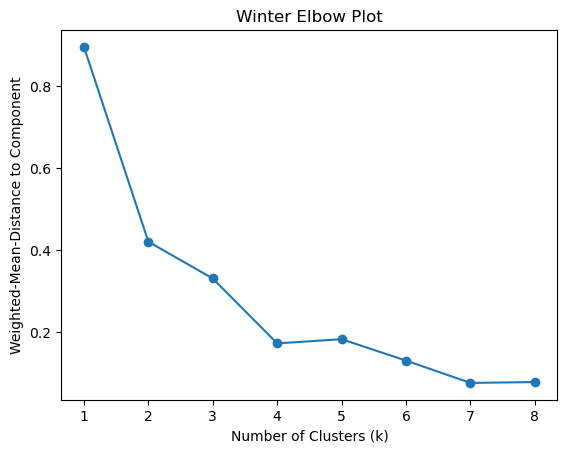

In [12]:
# Ensure columns are numeric and handle missing values if any
winter_df['LATITUDE'] = pd.to_numeric(winter_df['LATITUDE'], errors='coerce')
winter_df['LONGITUDE'] = pd.to_numeric(winter_df['LONGITUDE'], errors='coerce')

# Drop rows with missing values if necessary
winter_df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# Subset the DataFrame to include only numeric columns
winter_numeric = winter_df[['LATITUDE', 'LONGITUDE']]

k_values = [1,2,3,4,5,6,7,8]
distances = []

for k in k_values:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(winter_numeric,k)
    distances.append(mean_dist)
    
plt.plot(k_values, distances, marker = 'o')
plt.title('Winter Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Weighted-Mean-Distance to Component')
plt.show()

C:\Users\emman\AppData\Local\Temp\ipykernel_13984\2957749489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring_df['LATITUDE'] = pd.to_numeric(spring_df['LATITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\2957749489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring_df['LONGITUDE'] = pd.to_numeric(spring_df['LONGITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\2957749489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

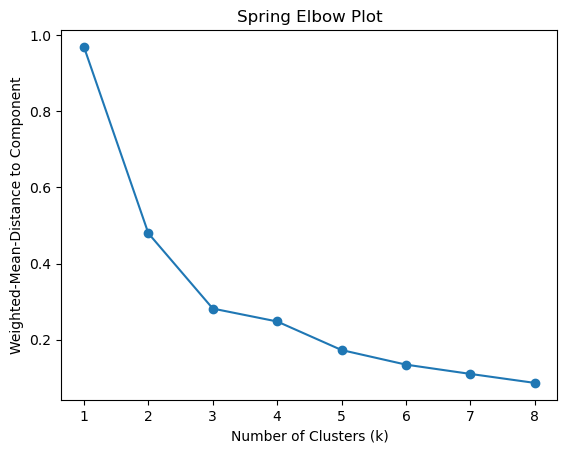

In [13]:
# Ensure columns are numeric and handle missing values if any
spring_df['LATITUDE'] = pd.to_numeric(spring_df['LATITUDE'], errors='coerce')
spring_df['LONGITUDE'] = pd.to_numeric(spring_df['LONGITUDE'], errors='coerce')

# Drop rows with missing values if necessary
spring_df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# Subset the DataFrame to include only numeric columns
spring_numeric = spring_df[['LATITUDE', 'LONGITUDE']]

k_values = [1,2,3,4,5,6,7,8]
distances = []

for k in k_values:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(spring_numeric,k)
    distances.append(mean_dist)
    
plt.plot(k_values, distances, marker = 'o')
plt.title('Spring Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Weighted-Mean-Distance to Component')
plt.show()

C:\Users\emman\AppData\Local\Temp\ipykernel_13984\3788603620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['LATITUDE'] = pd.to_numeric(summer_df['LATITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\3788603620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['LONGITUDE'] = pd.to_numeric(summer_df['LONGITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\3788603620.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

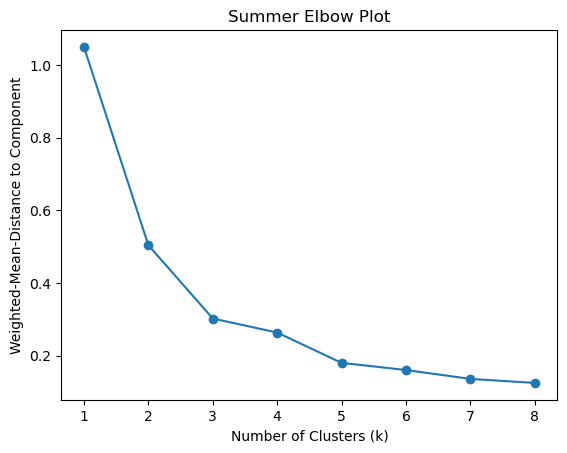

In [14]:
# Ensure columns are numeric and handle missing values if any
summer_df['LATITUDE'] = pd.to_numeric(summer_df['LATITUDE'], errors='coerce')
summer_df['LONGITUDE'] = pd.to_numeric(summer_df['LONGITUDE'], errors='coerce')

# Drop rows with missing values if necessary
summer_df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# Subset the DataFrame to include only numeric columns
summer_numeric = summer_df[['LATITUDE', 'LONGITUDE']]

k_values = [1,2,3,4,5,6,7,8]
distances = []

for k in k_values:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(summer_numeric,k)
    distances.append(mean_dist)
    
plt.plot(k_values, distances, marker = 'o')
plt.title('Summer Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Weighted-Mean-Distance to Component')
plt.show()

C:\Users\emman\AppData\Local\Temp\ipykernel_13984\1407165194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_df['LATITUDE'] = pd.to_numeric(fall_df['LATITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\1407165194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_df['LONGITUDE'] = pd.to_numeric(fall_df['LONGITUDE'], errors='coerce')
C:\Users\emman\AppData\Local\Temp\ipykernel_13984\1407165194.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

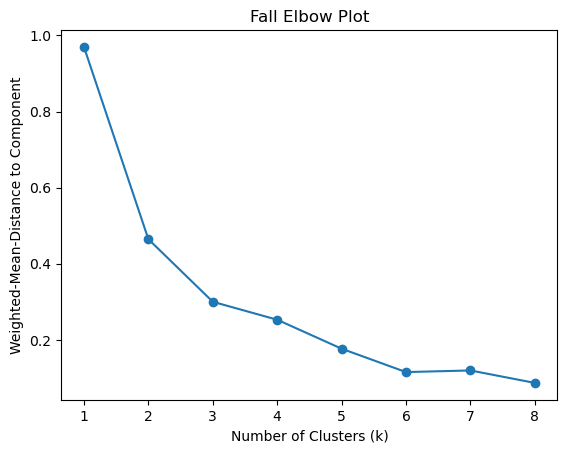

In [15]:
# Ensure columns are numeric and handle missing values if any
fall_df['LATITUDE'] = pd.to_numeric(fall_df['LATITUDE'], errors='coerce')
fall_df['LONGITUDE'] = pd.to_numeric(fall_df['LONGITUDE'], errors='coerce')

# Drop rows with missing values if necessary
fall_df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

# Subset the DataFrame to include only numeric columns
fall_numeric = fall_df[['LATITUDE', 'LONGITUDE']]

k_values = [1,2,3,4,5,6,7,8]
distances = []

for k in k_values:
    p_class_given_data, means, covars, p_class, mean_dist = GMM(fall_numeric,k)
    distances.append(mean_dist)
    
plt.plot(k_values, distances, marker = 'o')
plt.title('Fall Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Weighted-Mean-Distance to Component')
plt.show()

In [16]:
# # perform GMM for k=3
# p_class_given_data, means, covars, p_class, mean_dist = GMM(df_numeric, 4)

# # determine the cluster assignment for each data point
# cluster_assignment = np.argmax(p_class_given_data, axis=1)

# # plot data points with color according to the cluster assignment
# plt.scatter(df_numeric['LATITUDE'], df_numeric['LONGITUDE'], c=cluster_assignment, cmap='viridis', s=10)
# plt.title('Full Dataframe (k=4)')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
# plt.colorbar(label='Cluster')
# plt.show()

# # Count the number of data points in each cluster
# cluster_counts = np.bincount(cluster_assignment)

# # Total number of data points
# total_points = len(cluster_assignment)

# # Calculate the percentage of cluster coverage
# cluster_coverage_percent = (cluster_counts / total_points) * 100

# # Display the cluster coverage percentage
# for i, coverage in enumerate(cluster_coverage_percent):
#     print(f"Cluster {i}: {coverage:.2f}%")
    
# fall_df['CLUSTER'] = cluster_assignment

# df = fall_df[['COMMON NAME', 'CLUSTER']]

# # subset for names that occur x number of times
# # Step 1: Count the occurrences of each name
# name_counts = df['COMMON NAME'].value_counts()

# # Step 2: Define the threshold
# threshold = 10000  # Example threshold

# # Step 3: Filter names based on the count threshold
# filtered_names = name_counts[name_counts > threshold].index.tolist()

# # Step 4: Subset the original DataFrame using filtered names
# df = df[df['COMMON NAME'].isin(filtered_names)]


# # Group by name and cluster, then count occurrences
# name_cluster_counts = df.groupby(['COMMON NAME', 'CLUSTER']).size().unstack(fill_value=0)

# # Plotting
# name_cluster_counts.plot(kind='bar', stacked=True)
# plt.xlabel('Name')
# plt.ylabel('Count')
# plt.title('Cluster Counts for Each Name')
# plt.legend(title='Cluster')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show()

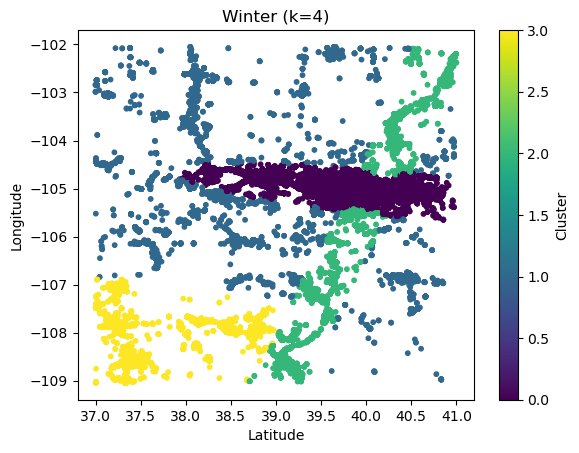

Cluster 0: 84.76%
Cluster 1: 3.89%
Cluster 2: 6.33%
Cluster 3: 5.02%


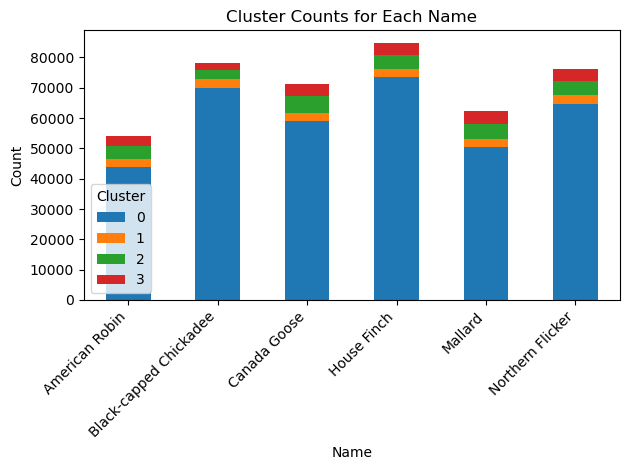

In [21]:
# Perform GMM for k=4 on the numeric data
p_class_given_data, means, covars, p_class, mean_dist = GMM(winter_numeric, 4)

# Determine the cluster assignment for each data point
cluster_assignment = np.argmax(p_class_given_data, axis=1)

# Plot data points with color according to the cluster assignment
plt.scatter(winter_numeric['LATITUDE'], winter_numeric['LONGITUDE'], c=cluster_assignment, cmap='viridis', s=10)
plt.title('Winter (k=4)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.show()

# Count the number of data points in each cluster
cluster_counts = np.bincount(cluster_assignment)

# Total number of data points
total_points = len(cluster_assignment)

# Calculate the percentage of cluster coverage
cluster_coverage_percent = (cluster_counts / total_points) * 100

# Display the cluster coverage percentage
for i, coverage in enumerate(cluster_coverage_percent):
    print(f"Cluster {i}: {coverage:.2f}%")
    
winter_df['CLUSTER'] = cluster_assignment

df = winter_df[['COMMON NAME', 'CLUSTER']]

# subset for names that occur x number of times
# Step 1: Count the occurrences of each name
name_counts = df['COMMON NAME'].value_counts()

# Step 2: Define the threshold
threshold = 5000  # Example threshold

# Step 3: Filter names based on the count threshold
filtered_names = name_counts[name_counts > threshold].index.tolist()

# Step 4: Subset the original DataFrame using filtered names
df = df[df['COMMON NAME'].isin(filtered_names)]

# Group by name and cluster, then count occurrences
name_cluster_counts = df.groupby(['COMMON NAME', 'CLUSTER']).size().unstack(fill_value=0)

# Plotting
name_cluster_counts.plot(kind='bar', stacked=True)
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Cluster Counts for Each Name')
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

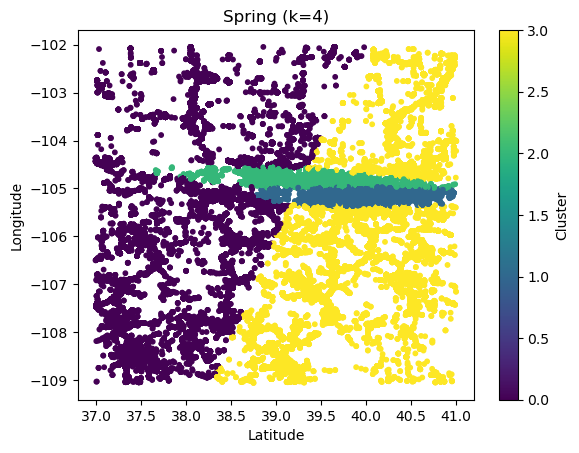

Cluster 0: 11.76%
Cluster 1: 51.17%
Cluster 2: 25.34%
Cluster 3: 11.73%


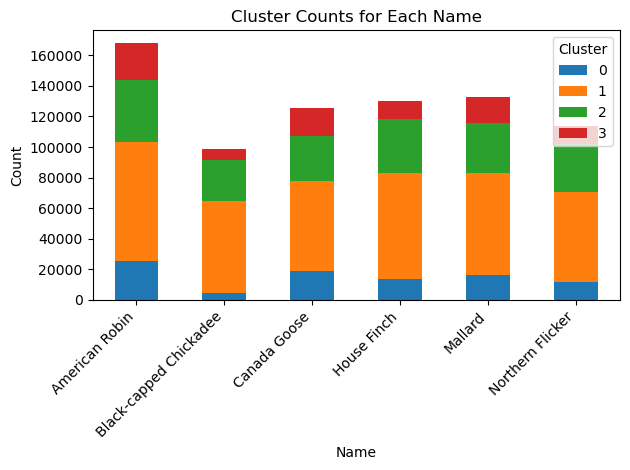

In [22]:
# perform GMM for k=4
p_class_given_data, means, covars, p_class, mean_dist = GMM(spring_numeric, 4)

# determine the cluster assignment for each data point
cluster_assignment = np.argmax(p_class_given_data, axis=1)

# plot data points with color according to the cluster assignment
plt.scatter(spring_numeric['LATITUDE'], spring_numeric['LONGITUDE'], c=cluster_assignment, cmap='viridis', s=10)
plt.title('Spring (k=4)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.show()

# Count the number of data points in each cluster
cluster_counts = np.bincount(cluster_assignment)

# Total number of data points
total_points = len(cluster_assignment)

# Calculate the percentage of cluster coverage
cluster_coverage_percent = (cluster_counts / total_points) * 100

# Display the cluster coverage percentage
for i, coverage in enumerate(cluster_coverage_percent):
    print(f"Cluster {i}: {coverage:.2f}%")
    
spring_df['CLUSTER'] = cluster_assignment

df = spring_df[['COMMON NAME', 'CLUSTER']]

# subset for names that occur x number of times
# Step 1: Count the occurrences of each name
name_counts = df['COMMON NAME'].value_counts()

# Step 2: Define the threshold
threshold = 5000  # Example threshold

# Step 3: Filter names based on the count threshold
filtered_names = name_counts[name_counts > threshold].index.tolist()

# Step 4: Subset the original DataFrame using filtered names
df = df[df['COMMON NAME'].isin(filtered_names)]

# Group by name and cluster, then count occurrences
name_cluster_counts = df.groupby(['COMMON NAME', 'CLUSTER']).size().unstack(fill_value=0)

# Plotting
name_cluster_counts.plot(kind='bar', stacked=True)
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Cluster Counts for Each Name')
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

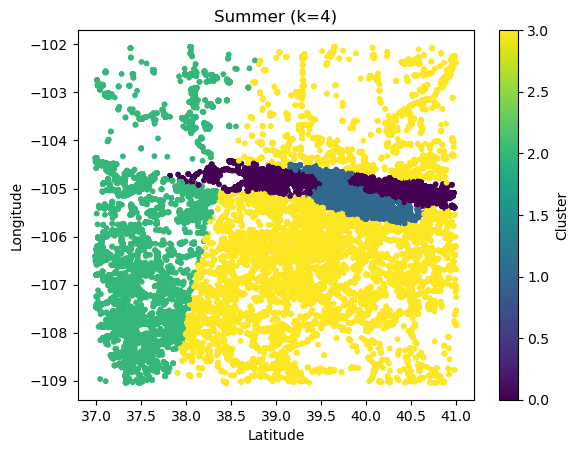

Cluster 0: 24.73%
Cluster 1: 46.26%
Cluster 2: 7.50%
Cluster 3: 21.51%


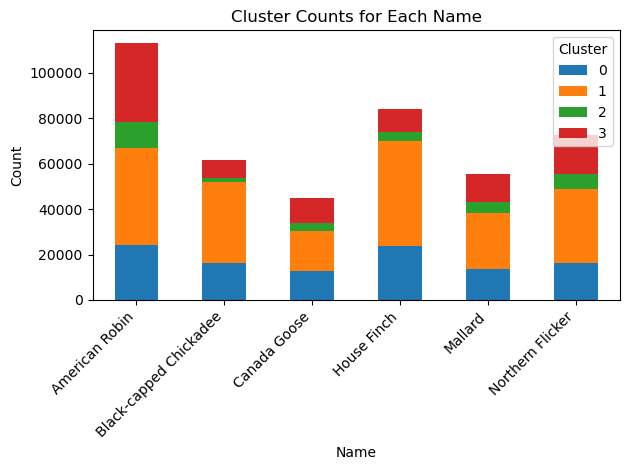

In [23]:
# perform GMM for k=4
p_class_given_data, means, covars, p_class, mean_dist = GMM(summer_numeric, 4)

# determine the cluster assignment for each data point
cluster_assignment = np.argmax(p_class_given_data, axis=1)

# plot data points with color according to the cluster assignment
plt.scatter(summer_numeric['LATITUDE'], summer_numeric['LONGITUDE'], c=cluster_assignment, cmap='viridis', s=10)
plt.title('Summer (k=4)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.show()

# Count the number of data points in each cluster
cluster_counts = np.bincount(cluster_assignment)

# Total number of data points
total_points = len(cluster_assignment)

# Calculate the percentage of cluster coverage
cluster_coverage_percent = (cluster_counts / total_points) * 100

# Display the cluster coverage percentage
for i, coverage in enumerate(cluster_coverage_percent):
    print(f"Cluster {i}: {coverage:.2f}%")
    
summer_df['CLUSTER'] = cluster_assignment

df = summer_df[['COMMON NAME', 'CLUSTER']]

# subset for names that occur x number of times
# Step 1: Count the occurrences of each name
name_counts = df['COMMON NAME'].value_counts()

# Step 2: Define the threshold
threshold = 5000  # Example threshold

# Step 3: Filter names based on the count threshold
filtered_names = name_counts[name_counts > threshold].index.tolist()

# Step 4: Subset the original DataFrame using filtered names
df = df[df['COMMON NAME'].isin(filtered_names)]


# Group by name and cluster, then count occurrences
name_cluster_counts = df.groupby(['COMMON NAME', 'CLUSTER']).size().unstack(fill_value=0)

# Plotting
name_cluster_counts.plot(kind='bar', stacked=True)
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Cluster Counts for Each Name')
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

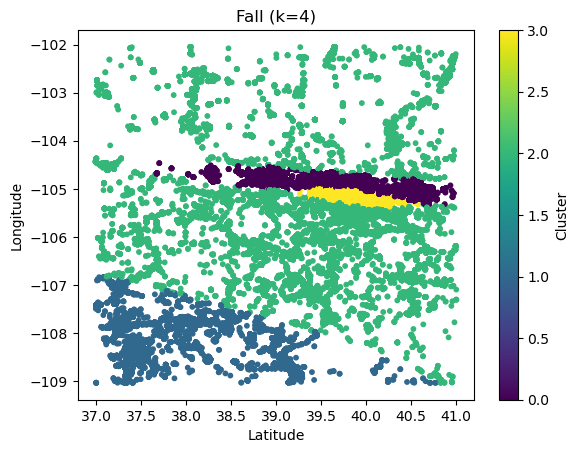

Cluster 0: 41.31%
Cluster 1: 9.12%
Cluster 2: 14.26%
Cluster 3: 35.31%


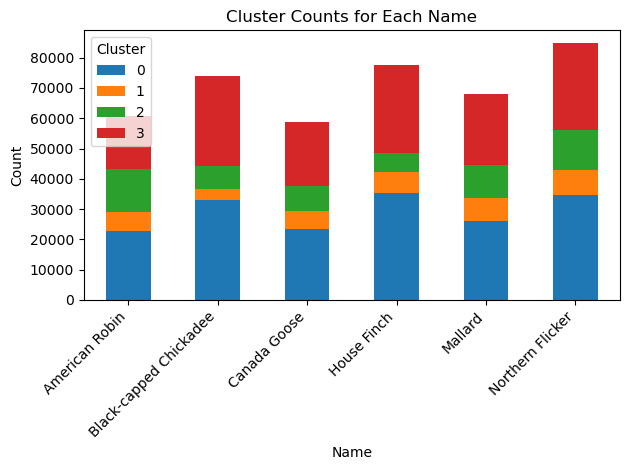

In [24]:
# perform GMM for k=4
p_class_given_data, means, covars, p_class, mean_dist = GMM(fall_numeric, 4)

# determine the cluster assignment for each data point
cluster_assignment = np.argmax(p_class_given_data, axis=1)

# plot data points with color according to the cluster assignment
plt.scatter(fall_numeric['LATITUDE'], fall_numeric['LONGITUDE'], c=cluster_assignment, cmap='viridis', s=10)
plt.title('Fall (k=4)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Cluster')
plt.show()

# Count the number of data points in each cluster
cluster_counts = np.bincount(cluster_assignment)

# Total number of data points
total_points = len(cluster_assignment)

# Calculate the percentage of cluster coverage
cluster_coverage_percent = (cluster_counts / total_points) * 100

# Display the cluster coverage percentage
for i, coverage in enumerate(cluster_coverage_percent):
    print(f"Cluster {i}: {coverage:.2f}%")
    
fall_df['CLUSTER'] = cluster_assignment

df = fall_df[['COMMON NAME', 'CLUSTER']]

# subset for names that occur x number of times
# Step 1: Count the occurrences of each name
name_counts = df['COMMON NAME'].value_counts()

# Step 2: Define the threshold
threshold = 5000  # Example threshold

# Step 3: Filter names based on the count threshold
filtered_names = name_counts[name_counts > threshold].index.tolist()

# Step 4: Subset the original DataFrame using filtered names
df = df[df['COMMON NAME'].isin(filtered_names)]


# Group by name and cluster, then count occurrences
name_cluster_counts = df.groupby(['COMMON NAME', 'CLUSTER']).size().unstack(fill_value=0)

# Plotting
name_cluster_counts.plot(kind='bar', stacked=True)
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Cluster Counts for Each Name')
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()